In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [4]:
builder = tfds.builder("tf_flowers")
builder.download_and_prepare()
print(builder.info)

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)



In [5]:
(raw_train, raw_validation, raw_test) = builder.as_dataset(split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], as_supervised=True)

In [6]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


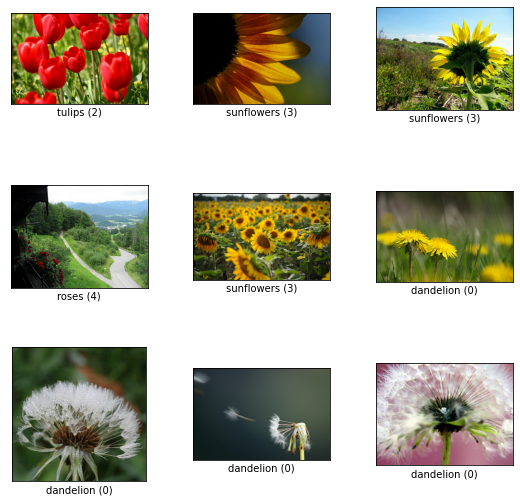

In [7]:
train_data = builder.as_dataset(split="train")
fig = tfds.show_examples(train_data, builder.info)

Show the first two images and labels from the training set:

In [8]:
IMG_SIZE = 150 # All images will be resized to 100x100

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = image = image / 255.0
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [9]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

# Baseline model

In [10]:
num_classes = builder.info.features['label'].num_classes # 5 CLASSES

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import RMSprop

# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B

# Write your neural network here!
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
# x = layers.Conv2D(16, 3, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
# x = layers.Conv2D(32, 3, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, activation='relu')(x)
# x = layers.Convolution2D(64, 3, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)
# x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))(x)

# TODO 1. Add a dropout layer with a dropout rate of 0.2
x = layers.Dropout(rate=0.2, seed=42)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(5, activation='softmax')(x)

In [11]:
# Configure and compile the model
model = Model(img_input, output, name='baseline')

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(lr=0.001),
            #   optimizer='adam',
              metrics=['acc'])

In [12]:
model.summary()

Model: "baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0  

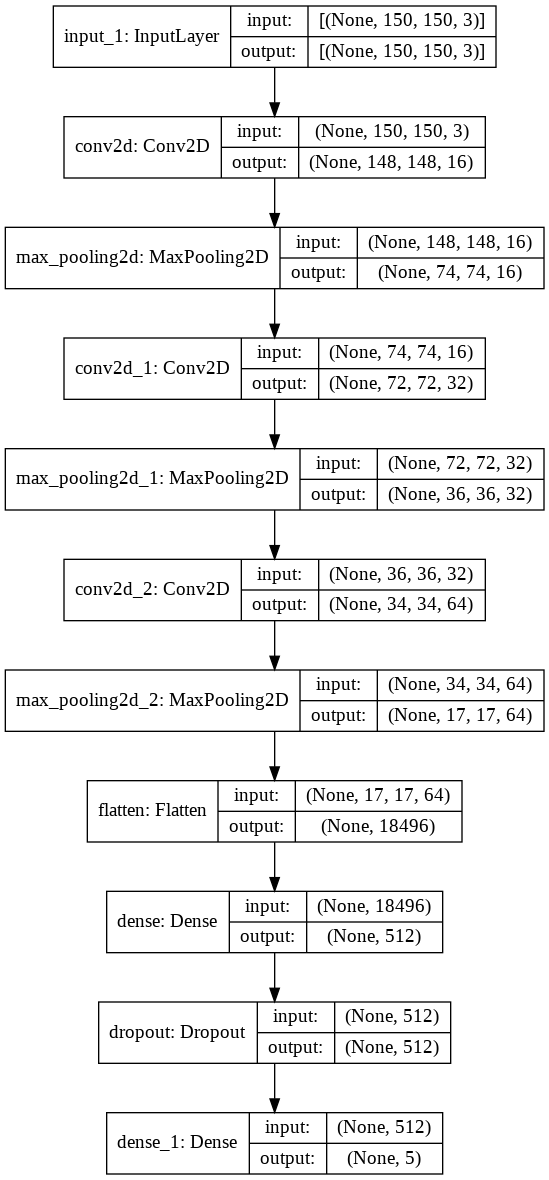

In [13]:
# NN model plot
tf.keras.utils.plot_model(model, to_file='baseline_structure.png', show_shapes=True, show_layer_names=True)

In [14]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [15]:
# adding callbacks -> earlystopping
my_callbacks = [
                tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]


In [16]:
#fit the model
history = model.fit(train_batches,
                    epochs=100,
                    validation_data=validation_batches,
                    callbacks=my_callbacks)

Epoch 1/100
23/23 [==============================] - 12s 301ms/step - loss: 2.5428 - acc: 0.2548 - val_loss: 1.3164 - val_acc: 0.4523
Epoch 2/100
23/23 [==============================] - 5s 162ms/step - loss: 1.2908 - acc: 0.4611 - val_loss: 1.1540 - val_acc: 0.5640
Epoch 3/100
23/23 [==============================] - 4s 155ms/step - loss: 1.1381 - acc: 0.5557 - val_loss: 1.0462 - val_acc: 0.5913
Epoch 4/100
23/23 [==============================] - 4s 154ms/step - loss: 1.0390 - acc: 0.5995 - val_loss: 1.0468 - val_acc: 0.5831
Epoch 5/100
23/23 [==============================] - 4s 156ms/step - loss: 0.9368 - acc: 0.6409 - val_loss: 0.9206 - val_acc: 0.6294
Epoch 6/100
23/23 [==============================] - 4s 161ms/step - loss: 0.8221 - acc: 0.6677 - val_loss: 0.9991 - val_acc: 0.5913
Epoch 7/100
23/23 [==============================] - 4s 156ms/step - loss: 0.7246 - acc: 0.7316 - val_loss: 1.2296 - val_acc: 0.5722
Epoch 8/100
23/23 [==============================] - 4s 157ms/step -

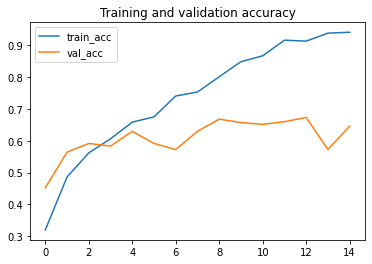

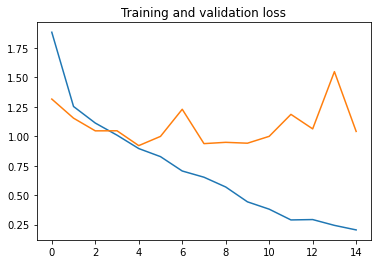

In [17]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = 'train_acc')
plt.plot(epochs, val_acc, label = 'val_acc')
plt.title('Training and validation accuracy')

# save fig
plt.savefig('baseline_accuracy')

plt.legend()
plt.figure()


# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

# save fig
plt.savefig('baseline_loss')

# M1 model

In [18]:
num_classes = builder.info.features['label'].num_classes # 5 CLASSES

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import RMSprop

# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B

# Write your neural network here!
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
# x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.Conv2D(16, 3, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
# x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(32, 3, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
# x = layers.Convolution2D(64, 3, activation='relu')(x)
x = layers.Convolution2D(64, 3, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
# x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)

# TODO 1. Add a dropout layer with a dropout rate of 0.2
x = layers.Dropout(rate=0.2, seed=42)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(5, activation='softmax')(x)

In [19]:
# Configure and compile the model
model_1 = Model(img_input, output, name='M1')

model_1.compile(loss='sparse_categorical_crossentropy',
            #   optimizer=RMSprop(lr=0.001),
              optimizer='adam',
              metrics=['acc'])

In [20]:
model_1.summary()

Model: "M1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 64)        0        

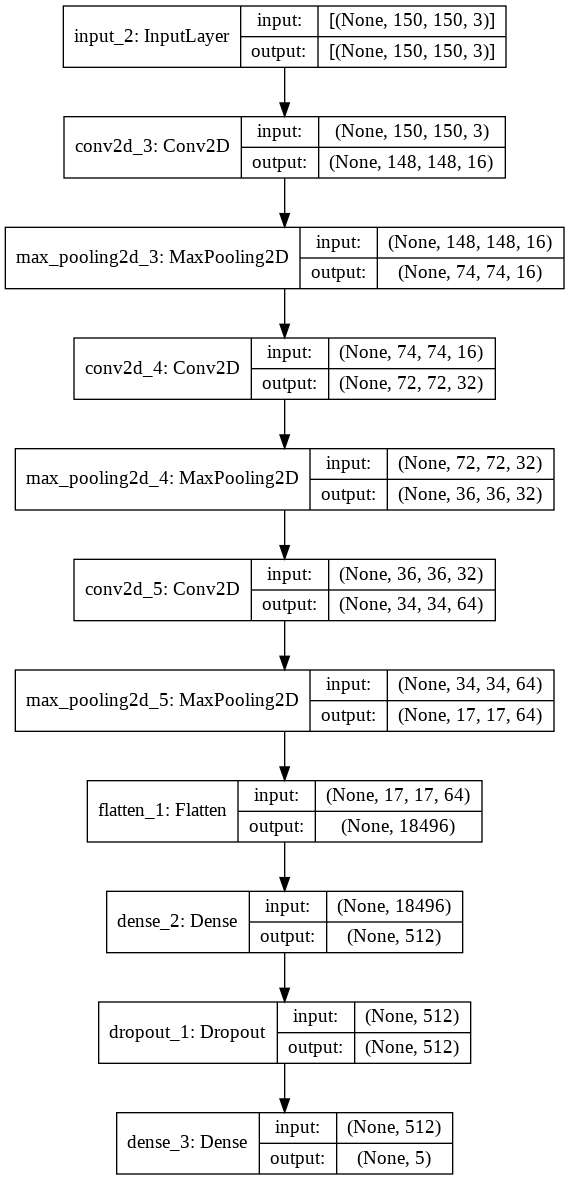

In [21]:
# NN model plot
tf.keras.utils.plot_model(model_1, to_file='M1_structure.png', show_shapes=True, show_layer_names=True)

In [22]:
#fit the model
history = model_1.fit(train_batches,
                    epochs=100,
                    validation_data=validation_batches,
                    callbacks=my_callbacks)

Epoch 1/100
23/23 [==============================] - 6s 178ms/step - loss: 3.2064 - acc: 0.2556 - val_loss: 1.8994 - val_acc: 0.4142
Epoch 2/100
23/23 [==============================] - 5s 164ms/step - loss: 1.8461 - acc: 0.4245 - val_loss: 1.6567 - val_acc: 0.5204
Epoch 3/100
23/23 [==============================] - 4s 160ms/step - loss: 1.5607 - acc: 0.5352 - val_loss: 1.4396 - val_acc: 0.6294
Epoch 4/100
23/23 [==============================] - 5s 165ms/step - loss: 1.3988 - acc: 0.5990 - val_loss: 1.4375 - val_acc: 0.5695
Epoch 5/100
23/23 [==============================] - 5s 175ms/step - loss: 1.3074 - acc: 0.6052 - val_loss: 1.4155 - val_acc: 0.5668
Epoch 6/100
23/23 [==============================] - 4s 156ms/step - loss: 1.2304 - acc: 0.6375 - val_loss: 1.2020 - val_acc: 0.6376
Epoch 7/100
23/23 [==============================] - 4s 156ms/step - loss: 1.1502 - acc: 0.6545 - val_loss: 1.1514 - val_acc: 0.6676
Epoch 8/100
23/23 [==============================] - 4s 159ms/step - 

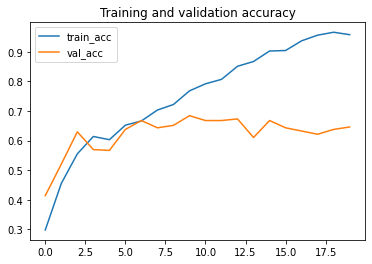

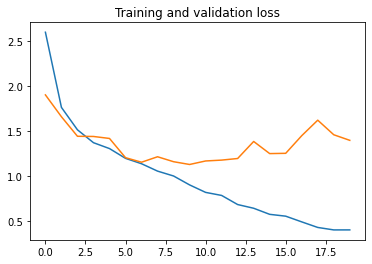

In [23]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = 'train_acc')
plt.plot(epochs, val_acc, label = 'val_acc')
plt.title('Training and validation accuracy')

# save fig
plt.savefig('M1_accuracy')

plt.legend()
plt.figure()


# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

# save fig
plt.savefig('M1_loss')

# **[TODO] IMPROVE THE MODEL BY USING INCEPTION V3**

In [24]:
# getting the weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


--2021-05-01 12:29:42--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 172.253.115.128, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   160MB/s    in 0.5s    

2021-05-01 12:29:43 (160 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [25]:
# import inceptionV3
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

In [26]:
# fix layers -> make them not trainable
for layer in pre_trained_model.layers:
  layer.trainable = False

In [27]:
# using feature extraction
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


# M2 model

In [28]:
# connect the last output
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2, seed=42)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(5, activation='softmax')(x)


In [29]:
# Configure and compile the model
model_2 = Model(pre_trained_model.input, x, name='M2')

model_2.compile(loss='sparse_categorical_crossentropy',
                # optimizer=RMSprop(lr=0.001),
                optimizer='adam',
                metrics=['acc'])

In [30]:
model_2.summary()

Model: "M2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d_6[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_________________________________________________________________________________________________

In [31]:
# NN model plot
tf.keras.utils.plot_model(model_2, to_file='M2_structure.png', show_shapes=True, show_layer_names=True)

In [32]:
history = model_2.fit(train_batches,
                    epochs=100,
                    validation_data=validation_batches,
                    verbose=2)

Epoch 1/100
23/23 - 14s - loss: 4.8855 - acc: 0.5909 - val_loss: 2.7123 - val_acc: 0.8120
Epoch 2/100
23/23 - 7s - loss: 2.2479 - acc: 0.9063 - val_loss: 2.1964 - val_acc: 0.8501
Epoch 3/100
23/23 - 6s - loss: 1.7030 - acc: 0.9588 - val_loss: 1.8655 - val_acc: 0.8283
Epoch 4/100
23/23 - 6s - loss: 1.3464 - acc: 0.9816 - val_loss: 1.5612 - val_acc: 0.8556
Epoch 5/100
23/23 - 6s - loss: 1.0904 - acc: 0.9956 - val_loss: 1.3817 - val_acc: 0.8583
Epoch 6/100
23/23 - 6s - loss: 0.9072 - acc: 0.9973 - val_loss: 1.2379 - val_acc: 0.8583
Epoch 7/100
23/23 - 7s - loss: 0.7692 - acc: 0.9980 - val_loss: 1.1164 - val_acc: 0.8529
Epoch 8/100
23/23 - 7s - loss: 0.6564 - acc: 0.9993 - val_loss: 1.0220 - val_acc: 0.8719
Epoch 9/100
23/23 - 7s - loss: 0.5710 - acc: 0.9997 - val_loss: 0.9399 - val_acc: 0.8556
Epoch 10/100
23/23 - 6s - loss: 0.5002 - acc: 0.9997 - val_loss: 0.8783 - val_acc: 0.8447
Epoch 11/100
23/23 - 7s - loss: 0.4442 - acc: 0.9986 - val_loss: 0.8245 - val_acc: 0.8501
Epoch 12/100
23/23

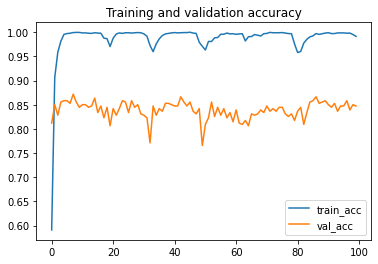

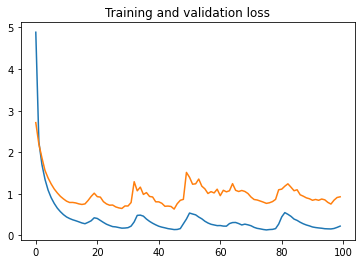

In [33]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = 'train_acc')
plt.plot(epochs, val_acc, label = 'val_acc')
plt.title('Training and validation accuracy')

# save fig
plt.savefig('M2_accuracy')

plt.legend()
plt.figure()


# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

# save fig
plt.savefig('M2_loss')